# Implementing GPT model from scratch

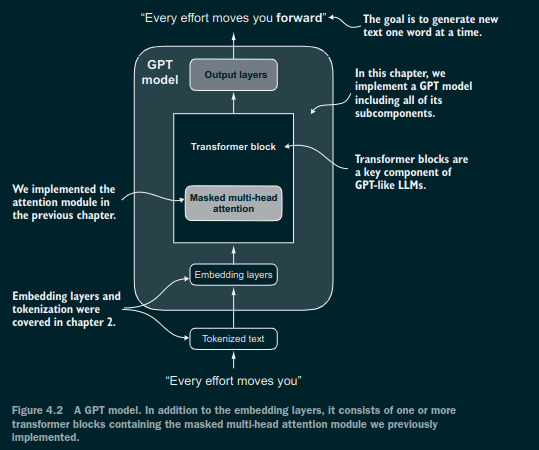

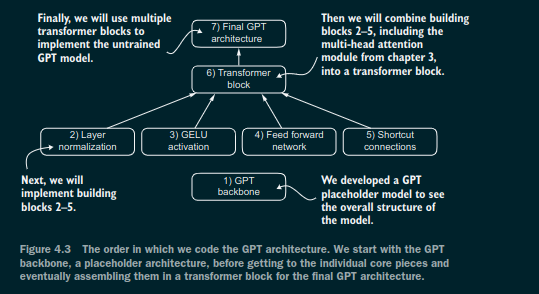

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
    }

# A placeholder GPT model architecture class

In [4]:
import torch 
import torch.nn as nn 

class DummyGPTModel(nn.Module):
    def __init__(self, cfg): 
        super().__init__() 
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) 
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) 
        self.out_head = nn.Linear( cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx): 
        batch_size, seq_len = in_idx.shape 
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds 
        x = self.drop_emb(x) 
        x = self.trf_blocks(x) 
        x = self.final_norm(x) 
        logits = self.out_head(x) 
        return logits

class DummyTransformerBlock(nn.Module): 
    def __init__(self, cfg): 
        super().__init__() 
        
    def forward(self, x): 
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
         super().__init__() 
         
    def forward(self, x): 
        return x

In [5]:
import tiktoken 
import torch 

tokenizer = tiktoken.get_encoding("gpt2") 
batch = []
txt1 = "Every effort moves you" 
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0) 
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


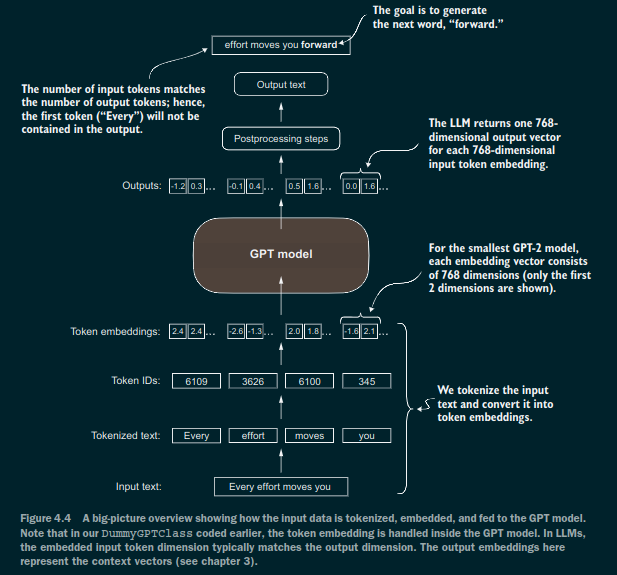

In [6]:
torch.manual_seed(123) 
model = DummyGPTModel(GPT_CONFIG_124M) 
logits = model(batch) 
print("Output shape:", logits.shape) 
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


# Layer Normalization
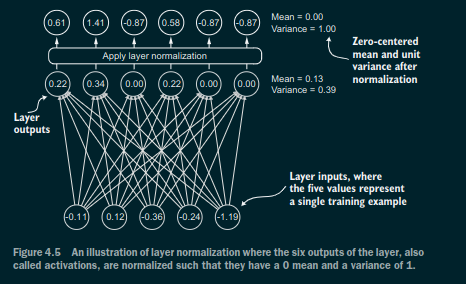

In [7]:
# Example for Normalization 

torch.manual_seed(123) 
batch_example = torch.randn(2, 5) 
print(batch_example)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) 
out = layer(batch_example) 
print(out)

mean = out.mean(dim=-1, keepdim=True) 
var = out.var(dim=-1, keepdim=True) 
print("========Before normalization=============")
print("Mean:\n", mean) 
print("Variance:\n", var)

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True) 
var = out_norm.var(dim=-1, keepdim=True) 
print("Normalized layer outputs:\n", out_norm) 
print("========After normalization================")
print("Mean:\n", mean)
print("Variance:\n", var)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
========Before normalization=============
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
========After normalization================
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
# A layer normalization class

class LayerNorm(nn.Module): 
    def __init__(self, emb_dim): 
        super().__init__()
        self.eps = 1e-5 
        self.scale = nn.Parameter(torch.ones(emb_dim)) 
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x): 
        mean = x.mean(dim=-1, keepdim=True) 
        var = x.var(dim=-1, keepdim=True, unbiased=False) 
        norm_x = (x - mean) / torch.sqrt(var + self.eps) 
        return self.scale * norm_x + self.shift
    
ln = LayerNorm(emb_dim=5) 
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True) 
var = out_ln.var(dim=-1, unbiased=False, keepdim=True) 
print("Mean:\n", mean) 
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU activation functions

GELU : Gaussian Error Linear Unit activation functions

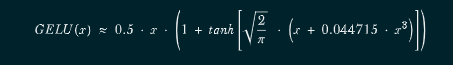

In [9]:
class GELU(nn.Module):
    def __init__(self): 
        super().__init__() 
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh( 
            torch.sqrt(torch.tensor(2.0 / torch.pi)) 
            *(x + 0.044715 * torch.pow(x, 3))
        ))

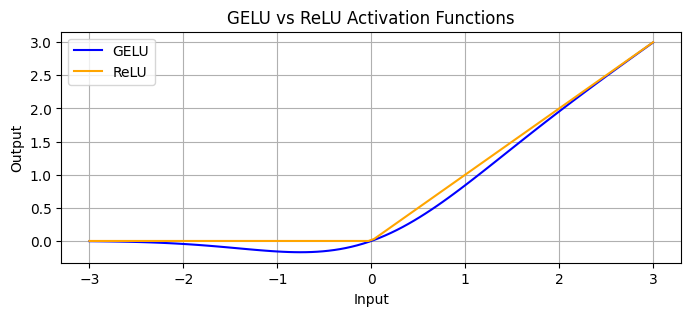

In [10]:
import matplotlib.pyplot as plt 
gelu, relu = GELU(), nn.ReLU() 
x = torch.linspace(-3, 3, 100) 
y_gelu, y_relu = gelu(x), relu(x) 
plt.figure(figsize=(8, 3)) 

# Plot x and y_gelu
plt.plot(x.numpy(), y_gelu.detach().numpy(), label='GELU', color='blue')

# Plot x and y_relu
plt.plot(x.numpy(), y_relu.detach().numpy(), label='ReLU', color='orange')

# Add labels, legend, title, and grid
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('GELU vs ReLU Activation Functions')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

##  A feed forward neural network module

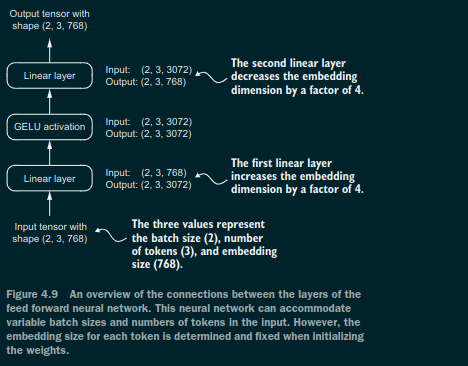

In [11]:
class FeedForward(nn.Module): 
    def __init__(self, cfg): 
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            ) 
            
    def forward(self, x): 
        return self.layers(x)

ffn = FeedForward(GPT_CONFIG_124M) 
x = torch.rand(2, 3, 768) 
out = ffn(x) 
print(out.shape)

torch.Size([2, 3, 768])


# Adding shortcut connections

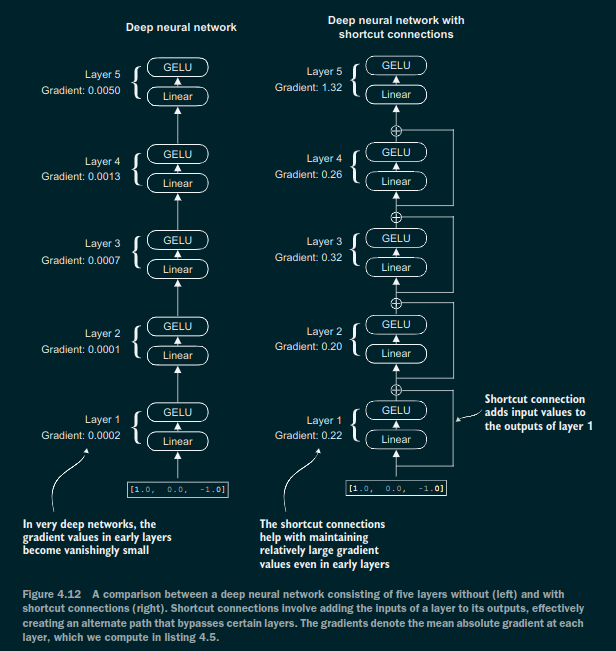

In [12]:
# A neural network to illustrate shortcut connections

class ExampleDeepNeuralNetwork(nn.Module): 
    def __init__(self, layer_sizes, use_shortcut): 
        super().__init__() 
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),
            ]
        )

    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
        

### Without shortcut connections

In [13]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]]) 
torch.manual_seed(123) 
model_without_shortcut = ExampleDeepNeuralNetwork( layer_sizes, use_shortcut=False)

def print_gradients(model, x): 
    output = model(x) 
    target = torch.tensor([[0.]]) 
    loss = nn.MSELoss() 
    loss = loss(output, target) 
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name: print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


### With shortcut connections

In [14]:
torch.manual_seed(123) 
model_with_shortcut = ExampleDeepNeuralNetwork( layer_sizes, use_shortcut=True) 
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# Connecting attention and linear layers in a transformer block

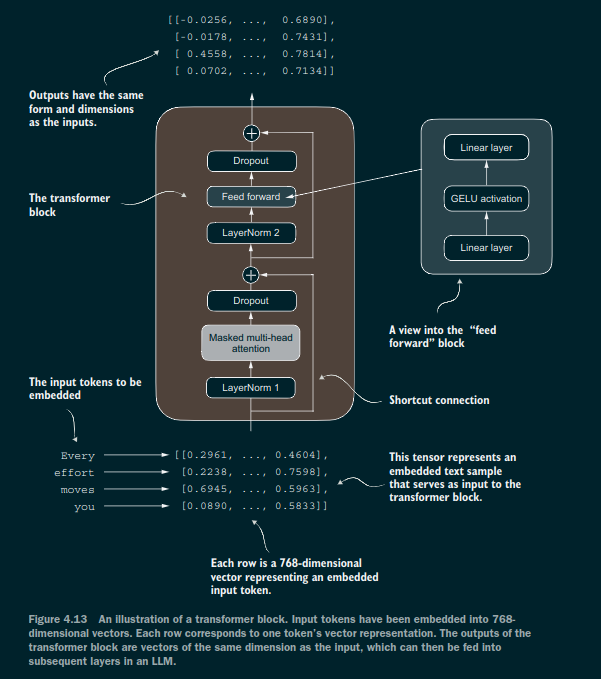

In [15]:
# The transformer block component of GPT

import nbimporter
from chp03_attention import MultiHeadAttention
import torch 
import torch.nn as nn 

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self,x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [16]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print(f'Input shape : {x.shape}')
print(f'Output shape : {output.shape}')


Input shape : torch.Size([2, 4, 768])
Output shape : torch.Size([2, 4, 768])


# Coding the GPT model

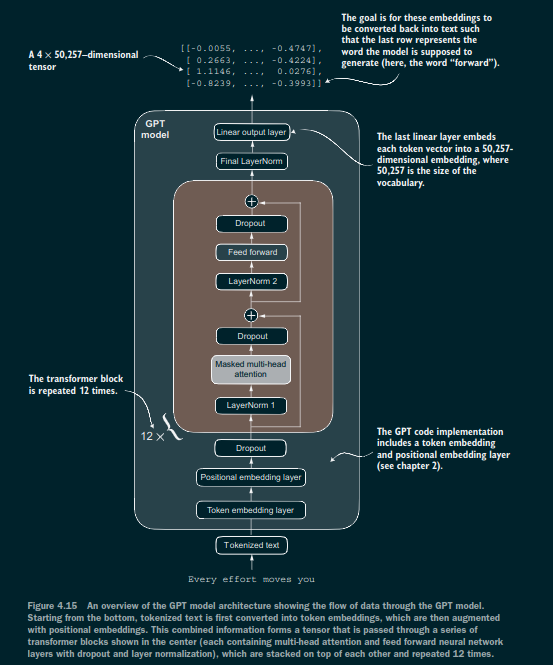

In [17]:
# The GPT model architecture implementation

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg)  for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias= False)

    def forward(self, in_idx):
        batch_size , seq_len = in_idx.shape
        token_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb( torch.arange(seq_len, device=in_idx.device))

        x = token_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [18]:
torch.manual_seed(123) 
model = GPTModel(GPT_CONFIG_124M) 
out = model(batch) 
print("Input batch:\n", batch) 
print("\nOutput shape:", out.shape) 
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


## Analysing the model architecture

In [19]:
total_params = sum(p.numel() for p in model.parameters()) 
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Wieght Type: The same weights used for token embeding is used for output layer to reduce the weights count so total weight count = total parameters - output paramets = 12 million parameter model

In [20]:
total_params_gpt2 = ( 
    total_params - sum(p.numel() 
    for p in model.out_head.parameters())
) 
print(f"Number of trainable parameters " f"considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


Calculating the memory requirments for our GPT model

In [21]:
total_size_bytes = total_params * 4  # since floating point represents 4 bytes
total_size_mb = total_size_bytes / (1024 * 1024) 
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


# Generating text

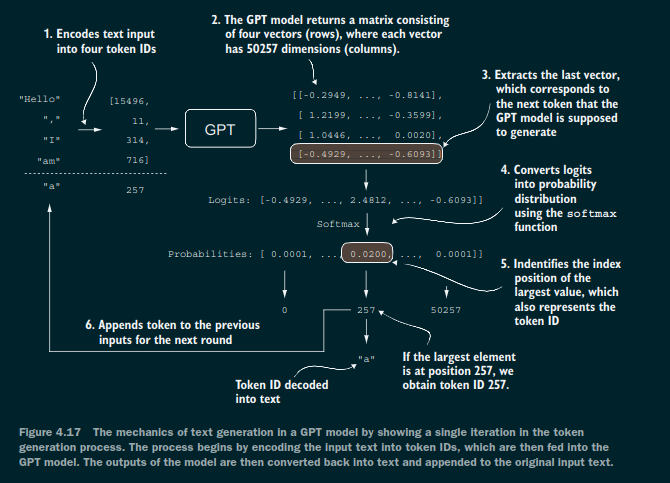

In [22]:
def generate_text_simple(model, idx, max_new_tokens, context_size): 
    for _ in range(max_new_tokens): 
        idx_cond = idx[:, -context_size:] 
        with torch.no_grad(): 
            logits = model(idx_cond) 
        
        logits = logits[:, -1, :] 
        probas = torch.softmax(logits, dim=-1) 
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) 
        idx = torch.cat((idx, idx_next), dim=1) 
        
    return idx

In [23]:
start_context = "Hello, I am" 
encoded = tokenizer.encode(start_context) 
print("encoded:", encoded) 
encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [26]:
model.eval() 
out = generate_text_simple( 
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
) 
print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Hello, I am Featureiman Byeswickattribute argue
